# Coding Exercise: Implementing a Squeeze-and-Excitation (SE) Block Using Keras

In this exercise, you will learn to implement a Squeeze-and-Excitation (SE) block, a key component introduced in the SENet architecture. The SE block is designed to improve the representational power of a neural network by adaptively recalibrating channel-wise feature responses.

The Squeeze-and-Excitation (SE) block was introduced in the paper ["Squeeze-and-Excitation Networks"](https://arxiv.org/abs/1709.01507) by Jie Hu, Li Shen, and Gang Sun. The SE block adaptively recalibrates channel-wise feature responses by explicitly modeling interdependencies between channels. It consists of two main operations:

1. **Squeeze Step**: Apply global average pooling across the spatial dimensions of the feature maps.
2. **Excitation Step**: Pass the result through a small bottleneck (a Dense layer with reduced dimensionality) to capture channel-wise dependencies. Re-expand the squeezed features back to the original number of channels using another Dense layer with a sigmoid activation to generate scaling factors.

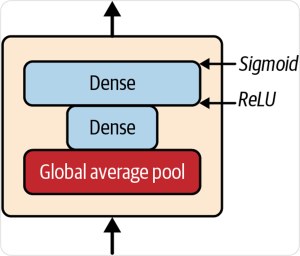

3. **Recalibrate Step**: Multiply the scaling factors with the original feature maps to recalibrate each channel.

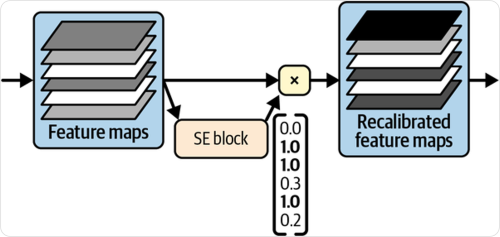

## Defining an SEBlock Layer

For this excercise your task is to complete the implementation of the SE block as a custom Keras layer. Steps:
1. Define the SE block as a subclass of `keras.layers.Layer`.
2. Implement the `__init__`, `build`, and `call` methods.
* `__init__`: Initialize the layer and set the reduction ratio.
* `build`: Define the weights or any operations that depend on the input shape.
* `call`: Implement the logic of the layer, which will apply the SE block operations (squeeze, excitation, and recalibration).
3. Integrate the custom SE block into a simple CNN model and test it.

You will need to use the following layers:
* [`GlobalAveragePooling2D`](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/): Global average pooling operation for 2D data.
* [`Dense`](https://keras.io/api/layers/core_layers/dense/): Just your regular densely-connected NN layer.
* [`Reshape`](https://keras.io/api/layers/reshaping_layers/reshape/): Layer that reshapes inputs into the given shape.
* [`Multiply`](https://keras.io/api/layers/merging_layers/multiply/):Performs elementwise multiplication. It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).

Refer to [Making new layers and models via subclassing
](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) for a more in-depth discussion of custom Layer definition.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        """
        Initilizes the layer
        Args:
            reduction_ratio (int): Reduction ratio for the bottleneck in the excitation step.
        """
        super(SEBlock, self).__init__(**kwargs) # Call to super __init__
        # Store the reduction_ratio as a class attribute
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        """
        Create the learnable parameters and define any layer operations.
        Args:
            input_shape (tuple): The shape of the input tensor (batch_size, height, width, channels).
        """
        # Get the number of input channels (~1 line)


        # Define block layers (add them as class attributes)
        # Define Global Average Pooling layer (~1 line)


        # Define 2 Dense layers (~1 line)
        # First Dense layer should "squeeze" number of channels by reduction_ratio
        # (for instance if input tensor has 64 channels and ratio is 16, squeeze into 4)
        # Use relu activation function


        # Second Dense layer should re-expand "squeezed" channels back to original number (~1 line)
        # Use sigmoid activation function


        # Define Reshape layer: make excitation vector of shape (channels) (~1 line)
        # multiply-compatible with intput tensor of shape (height, width, channels)


        # Define Multiply layer (~1 line)


        super(SEBlock, self).build(input_shape)

    def call(self, inputs):
        """
        Define the forward pass logic for the SE block.
        Args:
            inputs (tensor): Input tensor of shape (batch_size, height, width, channels).
        Returns:
            tensor: Output tensor after applying SE block (same shape as input).
        """
        # Step 1: Squeeze - Apply Global Average Pooling to inputs (~1 line)


        # Step 2: Excitation - Apply Bottleneck + Re-expansion layers to squeezed inputs (~2 line)


        # Reshape excitation to match input's channel dimension (~1 line)


        # Step 3: Recalibrate - Multiply inputs by the excitation (~1 line)


        return output

# Example of using the SEBlock in a model
input_tensor = tf.keras.Input(shape=(32, 32, 64))  # Example input tensor
output_tensor = SEBlock()(input_tensor)  # Apply the SEBlock

# Define a simple CNN model with SEBlock
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

model.summary()

As a quick sanity check, let's test your `SEBlock` with a random tensor. Input and output shapes should be identical.

In [ ]:
# Example input tensor (batch size, height, width, channels)
input_tensor = tf.random.normal([8, 32, 32, 64])

# Create an SEBlock instance
se_block = SEBlock()

# Apply the SEBlock to the input tensor
output_tensor = se_block(input_tensor)

# Check the output shape (should be the same as the input shape)
print(input_tensor.shape)
print(output_tensor.shape)

## Using the SEBlock Layer

Now that your `SEBlock` is ready, use it to build a simple CNN model for the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). We'll start by loading and preparing the data.

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. You can visualize a sample of this images with the code below.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
index = 0
for image in x_train[:9]:
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  #plt.title("Class: {}".format(class_names[label]))
  plt.axis("off")

plt.show()

It's time to build your model. The specific architecture is up to you, but make sure to employ the `SEBlock` and follow the design principles discussed in class (modularity, hierarchy, and reuse).

In [ ]:
def build_model_with_se(input_shape=(32, 32, 3), num_classes=10, se_ratio=16):
    inputs = layers.Input(shape=input_shape)

    # Define model's architecture (many lines)

    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model_with_se()
model.summary()

Complie and train your model.

Plot training and validation accuracy and loss.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Finally, evaluate with testing data (Note: model's test accuracy **won't** be factored into grade).

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")